__1. Set up data mining environment__

Load the processed data, remove unnecessary attributes, rename attributes for ease of referencing

In [7]:
import pandas as pd
import math, random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Specify the input CSV file and row number to split at
input_file = 'merged_datasets.csv'
# Function to separate CSV based on row number

# Read the input CSV file
df = pd.read_csv(input_file, header="infer")

# Split the DataFrame based on the row number
df = df.drop(columns=["HUMAN PLAYER POSITION (X) metres","HUMAN PLAYER POSITION (Y) metres","INITITAL VELOCITY OF SHUTTELCOCK(m/s)","INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)","SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","OUT_OF_COURT_SHOTS"])
df = df.rename(columns={"SHUTTLECOCK POSITIION IN AIR(X ) metres":"X","SHUTTLECOCK POSITIION IN AIR(Y) metres":"Y","SHUTTLECOCK POSITIION IN AIR(Z) metres":"Z"})

print(df.shape)
df

(65006, 4)


,SHOT_ID,X,Y,Z
0,1,4.075543,1.000000,1.662912
1,1,4.152007,1.000000,1.724866
2,1,4.228906,1.000000,1.788139
3,1,4.302100,1.000000,1.845245
4,1,4.376877,1.000000,1.904128
...,...,...,...,...
65001,448,8.953783,8.783813,1.096171
65002,448,8.968729,8.798245,0.870647
65003,448,8.984867,8.813831,0.639024
65004,448,9.001328,8.829726,0.398100


__2. Create training and testing set__

70:30 split used

In [8]:
numShots = df["SHOT_ID"].max()
print(numShots)
trainsetSize = int(numShots*0.7)
print(trainsetSize)
testsetSize = numShots-trainsetSize
traindata = df.loc[df["SHOT_ID"]<= trainsetSize]
testdata = df.loc[df["SHOT_ID"] > trainsetSize]
print(traindata.head())
print(testdata.head())

448
224
   SHOT_ID         X    Y         Z
0        1  4.075543  1.0  1.662912
1        1  4.152007  1.0  1.724866
2        1  4.228906  1.0  1.788139
3        1  4.302100  1.0  1.845245
4        1  4.376877  1.0  1.904128
       SHOT_ID         X         Y         Z
30838      225  4.050935  4.005353  1.685103
30839      225  4.099738  4.010483  1.771975
30840      225  4.149233  4.015685  1.854047
30841      225  4.198433  4.020856  1.933066
30842      225  4.247436  4.026007  2.011628


__3. Scale data to normalise__

In [3]:
scale = MinMaxScaler()
traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])
print(traindata.head())
print(testdata.head())

   SHOT_ID         X    Y         Z
0        1  0.005135  0.0  0.294019
1        1  0.019376  0.0  0.305632
2        1  0.033698  0.0  0.317492
3        1  0.047329  0.0  0.328197
4        1  0.061256  0.0  0.339234
       SHOT_ID         X         Y         Z
30838      225  0.000801  0.376565  0.250970
30839      225  0.010615  0.377207  0.264685
30840      225  0.020569  0.377859  0.277643
30841      225  0.030463  0.378507  0.290119
30842      225  0.040318  0.379152  0.302522


C:\Users\Esther\AppData\Local\Temp\ipykernel_28652\3751249483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
C:\Users\Esther\AppData\Local\Temp\ipykernel_28652\3751249483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])


__4. Functions to create X_train, Y_train, X_test and Y_test__

prepare_data(): Create feature set (X,Y,Z) and class labels (adjacent X,Y,Z)

prepare_data_deltas(): Create feature set (deltaX, deltaY, deltaZ) and class labels (adjacent deltaX, deltaY, deltaZ)

In [4]:
# Individual data points in X, Y
def prepare_data(data):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique(): # for each shot id
        shot_data = data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values
        for i in range(len(shot_data)):
            X.append(shot_data[i]) # get 1 set of datapoints
            Y.append(shot_data[i+1]) # get set of values that the datapoints should predict
    X = np.array(X)
    X = X.reshape(-1, 3)
    Y = np.array(Y)
    Y = Y.reshape(-1, 3)
    print(X.shape, Y.shape)
    return X, Y

# Delta between consecutive data points in X, Y
def prepare_data_deltas(data):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique(): # for each shot id
        shot_data = (data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values) # get xyz
        for i in range(len(shot_data)):
            X1 = shot_data[i]
            X2 = shot_data[i+1] 
            X.append(X2 - X1)
            Y1 = shot_data[i+1]
            Y2 = shot_data[i+2]
            Y.append(Y2 - Y1)
    X = np.array(X, dtype=object)
    X = np.concatenate(X)
    X = X.reshape(-1, 3)
    Y = np.array(Y, dtype=object)
    Y = np.concatenate(Y)
    Y = Y.reshape(-1, 3)
    # final shape should be n rows of 3
    print(X.shape, Y.shape)
    return X, Y

__5. Create X_train, Y_train, X_test, Y_test__

Sequence length dictates how many data points to use per shot

_For prepare_data():_

  - Attribute set contains 0..n XYZ values for each shot, and class labels containing 1..n+1 XYZ values of each shot

_For prepare_data_deltas():_

  - Attribute set contains n XYZ values for each shot, referring to i+1['X'] - i['X']. i+1['Y'] - i['Y'] and so on for values i in 0 to n.

  - Class labels contain n XYZ values for each shot, referring to i+2['X'] - i+1['X'], similar for Y and Z, for values i in 0 to n.

In [5]:
X_train, Y_train = prepare_data(traindata)

X_test, Y_test = prepare_data(testdata)

X_delta_train, Y_delta_train = prepare_data_deltas(traindata)

X_delta_test, Y_delta_test = prepare_data_deltas(testdata)


(20484, 3) (20484, 3)
(22770, 3) (22770, 3)
(20484, 3) (20484, 3)
(22770, 3) (22770, 3)


__6. Gaussian Process Regressor 1 (prepare_data())__

Train Gaussian Regressor on X_train and Y_train obtained through prepare_data()

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import joblib

kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.X_train_ = X_train
gpr.y_train_ = Y_train
gpr.n_features_in_ = 3
gpr.fit(X_train, Y_train)
joblib.dump(gpr, 'gpr.pkl')


__7. Gaussian Process Regressor 1 Performance__

GPR prediction, RMSE and plot

In [ ]:
# Convert predictions back to original scale for plotting
from sklearn.metrics import mean_squared_error

Y_pred = gpr.predict(X_test)

Y_test_inv = scale.inverse_transform(Y_test)
Y_pred_inv = scale.inverse_transform(Y_pred)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test_inv[:,0], Y_test_inv[:,1], Y_test_inv[:,2], color='b', label='Actual')
ax.scatter(Y_pred_inv[:,0], Y_pred_inv[:,1], Y_pred_inv[:,2], color='r',label='Predicted')
plt.legend()
plt.show()

__8. Gaussian Process Regressor 2 (predict_data_deltas())__

GPR_delta model, trained on X_delta_train and Y_delta_trained

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import joblib

kernel = RBF()
gpr_delta = GaussianProcessRegressor(kernel=kernel)
gpr_delta.X_train_ = X_delta_train
gpr_delta.y_train_ = Y_delta_train
gpr_delta.n_features_in_ = 3
gpr_delta.fit(X_delta_train, Y_delta_train)
joblib.dump(gpr_delta, 'gpr_delta.pkl')

c:\Users\Esther\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1))

__9. GPR2 Performance__

GPR prediction, RMSE and plot

Mean Squared Error: 0.12942557522113565
Root Mean Squared Error: 0.3597576617962926


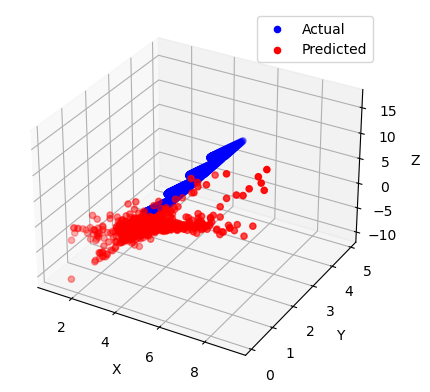

In [38]:
# Convert predictions back to original scale for plotting
from sklearn.metrics import mean_squared_error

Y_pred = gpr_delta.predict(X_delta_test)

Y_test_inv = scale.inverse_transform(Y_test)
Y_pred_inv = scale.inverse_transform(Y_pred)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test_inv[:,0], Y_test_inv[:,1], Y_test_inv[:,2], color='b', label='Actual')
ax.scatter(Y_pred_inv[:,0], Y_pred_inv[:,1], Y_pred_inv[:,2], color='r',label='Predicted')
plt.legend()
plt.show()

In [22]:
gpr.score(X_train, Y_train)
# joblib.dump(gpr, 'gaussian_process_model.pkl') # OSError: [Errno 28] No space left on device

0.9999999838022159

__10. Select GPR model and use for prediction__

GPR1: Given 1 point, predict the next.

In [ ]:
def predict_next_point(dataArr):
    for data in dataArr:
        diff = dataArr[data+1] - dataArr[data]
        diffPredict = gpr_delta.predict(diff)
    return diffPredict